<a href="https://colab.research.google.com/github/sairamadithya/lung-CT-classification/blob/main/lung_CT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

this code is about the classification of the chest CT images into one of the four cancerous conditions namely adenocarcinoma, large cell carcinoma, squamous cell carcinoma and normal.

In [1]:
import numpy as np
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from keras import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.models import * 
from tensorflow.keras.preprocessing import image

the dataset consists of about 1000 different lung CT images.

In [2]:
train_set='../input/chest-ctscan-images/Data/train'
val_set='../input/chest-ctscan-images/Data/valid'
test_set='../input/chest-ctscan-images/Data/test'

I have used imagedatagenerator to generate samples from the given image datasets by applying the specified transforms.

In [3]:
train_datagen = image.ImageDataGenerator(
    rotation_range=15,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    width_shift_range=0.1,
    height_shift_range=0.1
)
val_datagen= image.ImageDataGenerator(    rotation_range=15,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    width_shift_range=0.1,
    height_shift_range=0.1)
test_datagen= image.ImageDataGenerator(    rotation_range=15,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    width_shift_range=0.1,
    height_shift_range=0.1)

In [4]:
train_generator = train_datagen.flow_from_directory(
    train_set,
    target_size = (224,224),
    batch_size = 8,
    class_mode = 'categorical')
test_generator = test_datagen.flow_from_directory(
    val_set,
    target_size = (224,224),
    batch_size = 8,
    shuffle=True,
    class_mode = 'categorical')
validation_generator = test_datagen.flow_from_directory(
    test_set,
    target_size = (224,224),
    batch_size = 8,
    shuffle=True,
    class_mode = 'categorical')


Found 613 images belonging to 4 classes.
Found 72 images belonging to 4 classes.
Found 315 images belonging to 4 classes.


I have developed a transfer learning based EfficientNetB3 model that has been trained on imagenet dataset. I have added some additional layers to the basic model.

In [12]:
base_model = tf.keras.applications.EfficientNetB2(weights='imagenet', input_shape=(224,224,3), include_top=False)

for layer in base_model.layers:
    layer.trainable=False
model = Sequential()
model.add(base_model)
model.add(GaussianNoise(0.25))
model.add(GlobalAveragePooling2D())
model.add(Dense(256,activation='relu'))
model.add(BatchNormalization())
model.add(GaussianNoise(0.25))
model.add(Dropout(0.25))
model.add(Dense(4, activation='softmax'))
model.summary()

31801344/31790344 [==============================] - 0s 0us/step
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb2 (Functional)  (None, 7, 7, 1408)        7768569   
_________________________________________________________________
gaussian_noise_4 (GaussianNo (None, 7, 7, 1408)        0         
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1408)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               360704    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
gaussian_noise_5 (GaussianNo (None, 256)               0         
_______________________________________________________

The model has been compiled using cross entropy loss function, adam optimiser and the following metrics:

accuracy

AUC

precision

recall

In [13]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy','AUC','Precision','Recall'])

In [19]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
es=EarlyStopping(patience=3,monitor='val_loss')
filepath='best_model.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
history = model.fit(
    train_generator,
    epochs=18,
    validation_data=validation_generator,
    steps_per_epoch= 75,
    callbacks=checkpoint
    )

Epoch 1/18
75/75 [==============================] - 15s 205ms/step - loss: 0.5441 - accuracy: 0.7973 - auc: 0.9481 - precision: 0.8277 - recall: 0.7404 - val_loss: 0.8265 - val_accuracy: 0.6571 - val_auc: 0.8889 - val_precision: 0.6848 - val_recall: 0.6000

Epoch 00001: val_accuracy improved from -inf to 0.65714, saving model to best_model.h5
Epoch 2/18
75/75 [==============================] - 15s 203ms/step - loss: 0.5338 - accuracy: 0.7822 - auc: 0.9503 - precision: 0.8204 - recall: 0.7420 - val_loss: 0.7782 - val_accuracy: 0.7048 - val_auc: 0.9082 - val_precision: 0.7394 - val_recall: 0.6667

Epoch 00002: val_accuracy improved from 0.65714 to 0.70476, saving model to best_model.h5
Epoch 3/18
75/75 [==============================] - 15s 194ms/step - loss: 0.4728 - accuracy: 0.8040 - auc: 0.9606 - precision: 0.8435 - recall: 0.7672 - val_loss: 0.7593 - val_accuracy: 0.6857 - val_auc: 0.9069 - val_precision: 0.7292 - val_recall: 0.6413

Epoch 00003: val_accuracy did not improve from 0.

the model has produced the following results:

training accuracy= 94.13%

training loss= 0.1919

training precision= 95.45%

training recall= 92.5%

training AUC= 0.9953

In [20]:
model.evaluate(train_generator)

77/77 [==============================] - 10s 127ms/step - loss: 0.1919 - accuracy: 0.9413 - auc: 0.9953 - precision: 0.9545 - recall: 0.9250


[0.19189903140068054,
 0.9412724375724792,
 0.9952674508094788,
 0.9545454382896423,
 0.9249592423439026]

the model has produced the following results:

validation accuracy= 74.6%

validation loss= 0.6084

validation precision= 78.6%

validation recall= 71.11%

validation AUC= 0.9347

In [21]:
model.evaluate(validation_generator)

40/40 [==============================] - 5s 130ms/step - loss: 0.6084 - accuracy: 0.7460 - auc: 0.9347 - precision: 0.7860 - recall: 0.7111


[0.6083862781524658,
 0.7460317611694336,
 0.9347476363182068,
 0.7859649062156677,
 0.7111111283302307]

In [22]:
model.evaluate(test_generator)

9/9 [==============================] - 2s 184ms/step - loss: 0.5867 - accuracy: 0.7778 - auc: 0.9386 - precision: 0.7857 - recall: 0.7639


[0.5866916179656982,
 0.7777777910232544,
 0.9385930895805359,
 0.7857142686843872,
 0.7638888955116272]

[[0.9059036  0.00122325 0.07508809 0.01778515]]
THE UPLOADED IMAGE IS SUSPECTED AS: Adenocarcinoma


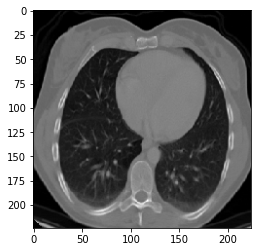

In [23]:
from keras.preprocessing import image
img = image.load_img('../input/chest-ctscan-images/Data/valid/adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib/000108 (7).png',target_size=(224,224))
imag = image.img_to_array(img)
imaga = np.expand_dims(imag,axis=0) 
ypred = model.predict(imaga)
print(ypred)
a=np.argmax(ypred,-1)
if a==0:
      op="Adenocarcinoma"
elif a==1:
      op="large cell carcinoma"
elif a==2:
      op="normal (void of cancer)"
else:
      op="squamous cell carcinoma"    
plt.imshow(img)
print("THE UPLOADED IMAGE IS SUSPECTED AS: "+str(op))  
